In [1]:
import re
import time

import torch
import pandas as pd
from torch import nn

from src import dataset, utils, models

# Text Classification

In [2]:
# Hyperparameters
EPOCHS = 20 # epoch
LR = 5  # learning rate
BATCH_SIZE = 8 # batch size for training

## Loading Data

In [3]:
df = pd.read_csv("./data/document_type_data.csv")[["text", "label"]]
code2label = dict(enumerate(df['label'].astype("category").cat.categories ) )
df.loc[:, "text"] = df["text"].str.lower().apply(lambda x : re.sub(r'[^a-zA-Z0-9 ]', '', x))
df

,text,label
0,chaikin karen n o o from sent to subje...,email
1,jenny after speaking with elisa about ...,email
2,please call with any questions thanks nw...,email
3,2085158326 williams carrie t lbco will b...,email
4,gj 3 a nice ending to the story below ...,email
...,...,...
95,curriculum vitae nilanjan roy name 1st o...,resumee
96,biographical sketch mark s ptashne profes...,resumee
97,may 1997 curriculum vitae education and ...,resumee
98,i curriculum vitae nabe emil r unanue ...,resumee


In [4]:
vocab, tokenizer = utils.get_vocab(df.set_index("label")["text"].iteritems())

In [5]:
train_df, val_df, test_df = utils.split_dataframe(df)
# initialize datasets
train_dataset = dataset.DocTextDataset(train_df, code2label, vocab, tokenizer)
val_dataset = dataset.DocTextDataset(val_df, code2label, vocab, tokenizer)
test_dataset = dataset.DocTextDataset(test_df, code2label, vocab, tokenizer)
print("Sizes:", len(train_dataset), len(val_dataset), len(test_dataset))

Sizes: 60 20 20


In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=False, collate_fn=utils.collate_batch)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=utils.collate_batch)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=utils.collate_batch)

## Define Model

As suggested in Pytorch's [Text Sentiment n-Grams classification](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html), the model is composed of the [nn.EmbeddingBag](https://pytorch.org/docs/stable/nn.html?highlight=embeddingbag#torch.nn.EmbeddingBag) layer plus a linear layer for the classification purpose. 

In [7]:
model = models.TextClassificationModel(
    vocab_size = len(train_dataset.vocab), 
    embed_dim = 64 ,
    num_class= len(train_dataset.code2label),
)

model = model.to(utils.get_device())

## Training

In [8]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

total_accu = None

metrics = pd.DataFrame(columns = ["epoch", "time", "train_accuracy", "valid_accuracy"])

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    utils.train(model, train_loader, criterion, optimizer, epoch)
    accu_train = utils.evaluate(model, train_loader)
    accu_val = utils.evaluate(model, val_loader)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
        
    metrics.loc[epoch, :] = [epoch, time.time() - epoch_start_time, accu_train, accu_val]                            

    print(f'| end of epoch {epoch:3d} | '
          + f'time: {time.time() - epoch_start_time:5.2f}s | '
          + f'train accuracy {accu_train:.1%} |'
          + f'valid accuracy {accu_val:.1%} |')

| end of epoch   1 | time:  0.09s | train accuracy 78.3% |valid accuracy 50.0% |
| end of epoch   2 | time:  0.06s | train accuracy 91.7% |valid accuracy 65.0% |
| end of epoch   3 | time:  0.09s | train accuracy 95.0% |valid accuracy 65.0% |
| end of epoch   4 | time:  0.07s | train accuracy 96.7% |valid accuracy 65.0% |
| end of epoch   5 | time:  0.06s | train accuracy 98.3% |valid accuracy 70.0% |
| end of epoch   6 | time:  0.06s | train accuracy 100.0% |valid accuracy 75.0% |
| end of epoch   7 | time:  0.07s | train accuracy 100.0% |valid accuracy 75.0% |
| end of epoch   8 | time:  0.07s | train accuracy 100.0% |valid accuracy 75.0% |
| end of epoch   9 | time:  0.06s | train accuracy 100.0% |valid accuracy 75.0% |
| end of epoch  10 | time:  0.07s | train accuracy 100.0% |valid accuracy 75.0% |
| end of epoch  11 | time:  0.09s | train accuracy 100.0% |valid accuracy 85.0% |
| end of epoch  12 | time:  0.08s | train accuracy 100.0% |valid accuracy 85.0% |
| end of epoch  13 | 

<AxesSubplot:>

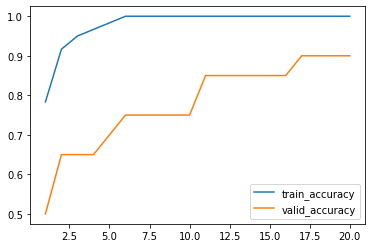

In [9]:
metrics[["train_accuracy", "valid_accuracy"]].plot()

## Testing

In [11]:
accu_test = utils.evaluate(model, test_loader)
print(f'test accuracy {accu_test:8.3f}')

test accuracy    0.750
